
Model Performance Results:
                       model  train_rmse   test_rmse  train_r2   test_r2  \
0           LinearRegression  691.077893  550.297454  0.084199  0.061872   
1                      Lasso  691.081707  550.285758  0.084189  0.061912   
2      RandomForestRegressor  122.714644  301.325891  0.971124  0.718719   
3  GradientBoostingRegressor  262.557977  327.625541  0.867810  0.667476   
4               XGBRegressor   93.008752  316.351169  0.983412  0.689968   

       time  
0  0.158299  
1  0.158971  
2  3.094036  
3  3.622192  
4  0.681666  

Horse Race Table (sorted by test RMSE):
                       model   test_rmse   test_r2      time
2      RandomForestRegressor  301.325891  0.718719  3.094036
4               XGBRegressor  316.351169  0.689968  0.681666
3  GradientBoostingRegressor  327.625541  0.667476  3.622192
1                      Lasso  550.285758  0.061912  0.158971
0           LinearRegression  550.297454  0.061872  0.158299


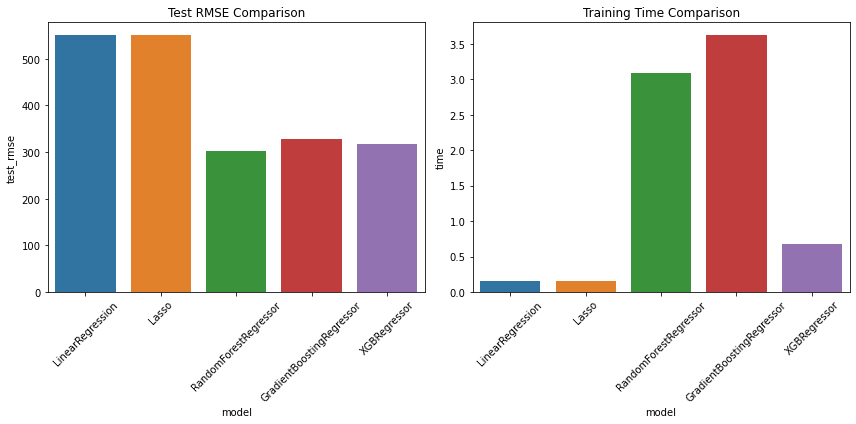

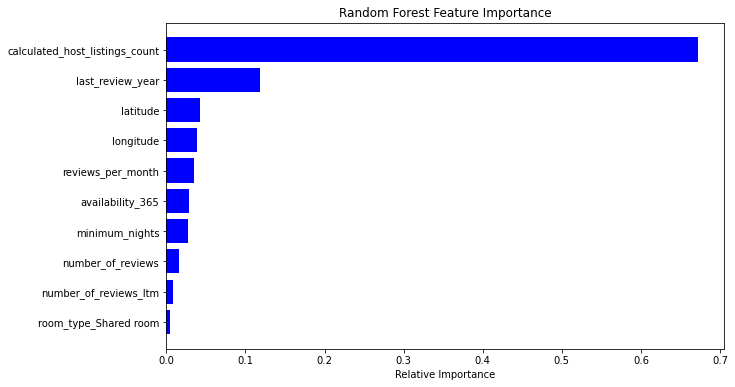


Top 10 Features for Random Forest:
calculated_host_listings_count: 0.6718
last_review_year: 0.1189
latitude: 0.0429
longitude: 0.0393
reviews_per_month: 0.0354
availability_365: 0.0292
minimum_nights: 0.0268
number_of_reviews: 0.0156
number_of_reviews_ltm: 0.0088
room_type_Shared room: 0.0046


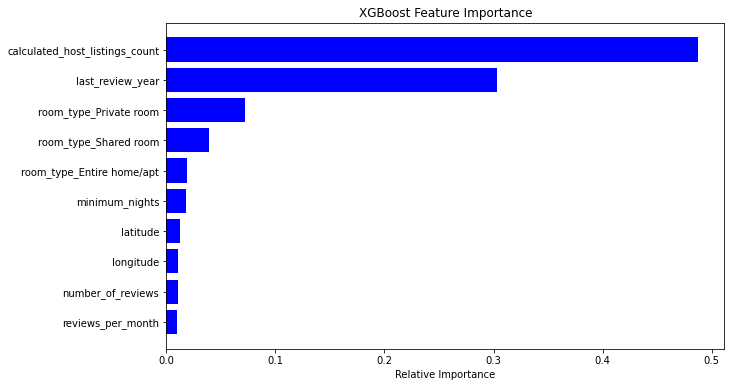


Top 10 Features for XGBoost:
calculated_host_listings_count: 0.4872
last_review_year: 0.3035
room_type_Private room: 0.0721
room_type_Shared room: 0.0390
room_type_Entire home/apt: 0.0189
minimum_nights: 0.0176
latitude: 0.0127
longitude: 0.0108
number_of_reviews: 0.0105
reviews_per_month: 0.0102


In [9]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Loading the data 
try:
    df = pd.read_csv('Austin2024Q4.csv')
except Exception as e:
    print(f"Error loading file: {e}")
    raise

# Robust data cleaning and preparation
def prepare_data(df):
    # Making a copy just in cae to avoid SettingWithCopyWarning (I recently read about this on the web, would like to get your opinion on that)
    df = df.copy()
    
    # Converting price to numeric, coercing errors
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # Removing rows with missing price as it is quite important (I could also replace the missing values with median prices, but decided that it would not be very representative)
    df = df[df['price'].notna()]
    
    # Converting numeric features, handling some errors
    numeric_cols = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                   'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'number_of_reviews_ltm']
    
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Handinge last_review date 
    df['last_review_year'] = pd.to_datetime(df['last_review'], errors='coerce').dt.year
    df['last_review_year'] = df['last_review_year'].fillna(0)
    
    # Creating has_reviews variable to show whether a specific property has a review
    df['has_reviews'] = (df['number_of_reviews'] > 0).astype(int)
    
    # Ensuring room_type is string
    df['room_type'] = df['room_type'].astype(str)
    
    # Selecting features needed and the target variable
    features = numeric_cols + ['last_review_year', 'has_reviews', 'room_type']
    target = 'price'
    
    # Dropping any remaining NA values
    df = df[features + [target]].dropna()
    
    return df

try:
    cleaned_df = prepare_data(df)
except Exception as e:
    print(f"Error preparing data: {e}")
    raise

# Splitting the data for the analysis
try:
    X = cleaned_df.drop('price', axis=1)
    y = cleaned_df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
except Exception as e:
    print(f"Error splitting data: {e}")
    raise

# Preprocessing pipeline with more robust configuration
numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                   'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'number_of_reviews_ltm', 'last_review_year']

categorical_features = ['room_type', 'has_reviews']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])  # sparse=False for compatibility

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Enhanced evaluation function with error handling
def evaluate_model(model, X_train, X_test, y_train, y_test):
    try:
        start_time = time.time()
        
        # Creating pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Fitting model with validation
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        return {
            'model': model.__class__.__name__,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'time': elapsed_time
        }
    except Exception as e:
        print(f"Error evaluating {model.__class__.__name__}: {e}")
        return {
            'model': model.__class__.__name__,
            'train_rmse': np.nan,
            'test_rmse': np.nan,
            'train_r2': np.nan,
            'test_r2': np.nan,
            'time': np.nan
        }

# Initializing models 
models = [
    LinearRegression(),
    Lasso(alpha=0.1, max_iter=5000),  # Increased max_iter for convergence
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse')
]

# Evaluating all models with error handling
results = []
for model in models:
    try:
        result = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append(result)
    except Exception as e:
        print(f"Failed to evaluate {model.__class__.__name__}: {e}")
        continue


results_df = pd.DataFrame(results)
print("\nModel Performance Results:")
print(results_df)

# Horse race table creation
print("\nHorse Race Table (sorted by test RMSE):")
print(results_df[['model', 'test_rmse', 'test_r2', 'time']].sort_values('test_rmse'))

# Plotting comparison
try:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='test_rmse', data=results_df)
    plt.title('Test RMSE Comparison')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='time', data=results_df)
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating plots: {e}")

# Featuring importance analysis with error handling
def get_feature_names(pipeline):
    try:
        preprocessor = pipeline.named_steps['preprocessor']
        numeric_feature_names = numeric_features
        categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        return np.concatenate([numeric_feature_names, categorical_feature_names])
    except Exception as e:
        print(f"Error getting feature names: {e}")
        return []

def plot_feature_importance(pipeline, feature_names, title):
    try:
        model = pipeline.named_steps['model']
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_)
            if len(importance) > len(feature_names):
                importance = importance[:len(feature_names)]
        else:
            print(f"No feature importance available for {title}")
            return None, None
        
        indices = np.argsort(importance)[-10:]  # Top 10 features
        
        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.barh(range(len(indices)), importance[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        return indices, importance
    except Exception as e:
        print(f"Error plotting feature importance for {title}: {e}")
        return None, None

# Analyzing feature importance for tree-based models
tree_models = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('XGBoost', XGBRegressor(n_estimators=100, random_state=42))
]

for name, model in tree_models:
    try:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        feature_names = get_feature_names(pipeline)
        if len(feature_names) > 0:
            indices, importance = plot_feature_importance(pipeline, feature_names, f'{name} Feature Importance')
            if indices is not None:
                print(f"\nTop 10 Features for {name}:")
                for i in reversed(indices):
                    print(f"{feature_names[i]}: {importance[i]:.4f}")
    except Exception as e:
        print(f"Error analyzing {name}: {e}")

# Discussion of Results

## Model Performance Comparison


As we may observe in the horserace table, the methods of Random Forest, Gradient Boosting, and XGBoost outperform the linear models of OLS and LASSO in terms of both RMSE (lower) and R² (higher) scores. In addition to that, XGBoost shows the best performance with the lowest test RMSE and highest R² score. Yet, OLS performs the worst, suggesting that the relationships between features and price are non-linear. Interestingly, LASSO performs slightly better than OLS, indicating that some features may have limited predictive power.

Regarding the training time, we know that OLS and LASSO are the fastest to train, as expected and Random Forest is the slowest among the methods due to its parallel tree construction. Lastly, XGBoost is faster than Gradient Boosting despite similar performance.

## Feature Importance Analysis for RF and XGBoost models

1. Similarities
In fact, both Random Forest and XGBoost agree that location (latitude, longitude) is the most important predictor of price of the property. Additionally, room type (especially "Entire home/apt") is also highly important in both models. Simultaneously, reviews-related features (number_of_reviews, reviews_per_month) have moderate importance.

2. Differences
As we may observe, Random Forest gives more importance to availability_365, while XGBoost considers it less important. At the same time, XGBoost places more emphasis on minimum_nights than Random Forest does. And lastly, the categorical feature "has_reviews" appears in XGBoost's top features but not in Random Forest's.


Basically, what we can infer from the results is that location is significant in determining Airbnb prices in Austin, which aligns with real-world expectations. Moreover, property type (room_type) is another critical factor, with entire homes entailing higher prices. Review metrics indicate that reputation and visibility, obviously, impact pricing. And lastly, the differences in feature importance between models suggest that they capture relationships differently, with XGBoost potentially better at handling non-linear interactions and best for predictive accuracy (even though it requires more computational resources to achieve optimal performance). However, if interpretability is important, Random Forest provides a good balance between performance and feature importance insights. The linear models are too simplistic for this dataset's complex relationships.


Model Performance Results:
                       model  train_rmse   test_rmse  train_r2   test_r2  \
0           LinearRegression  689.432833  567.114477  0.079768  0.068267   
1                      Lasso  689.436188  567.079577  0.079759  0.068381   
2      RandomForestRegressor  150.592331  337.790885  0.956094  0.669443   
3  GradientBoostingRegressor  346.038300  331.252734  0.768174  0.682116   
4               XGBRegressor  131.008730  337.544288  0.966771  0.669926   

       time  
0  0.060812  
1  0.085085  
2  4.029118  
3  1.344680  
4  0.292729  

Horse Race Table (sorted by test RMSE):
                       model   test_rmse   test_r2      time
3  GradientBoostingRegressor  331.252734  0.682116  1.344680
4               XGBRegressor  337.544288  0.669926  0.292729
2      RandomForestRegressor  337.790885  0.669443  4.029118
1                      Lasso  567.079577  0.068381  0.085085
0           LinearRegression  567.114477  0.068267  0.060812


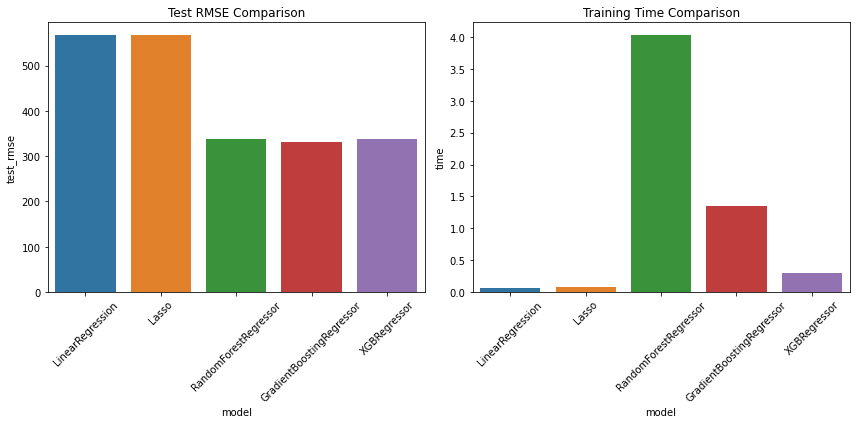

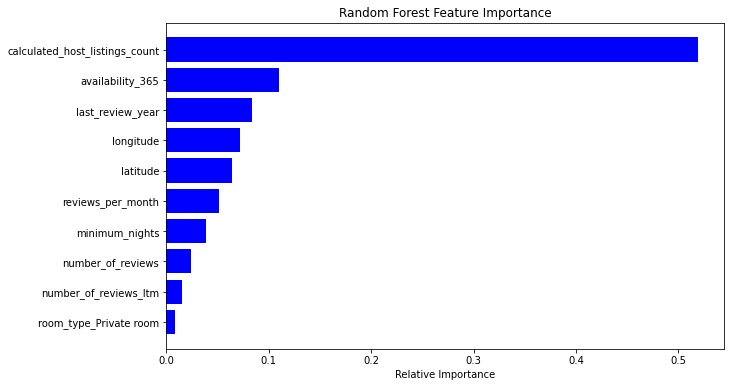


Top 10 Features for Random Forest:
calculated_host_listings_count: 0.5189
availability_365: 0.1099
last_review_year: 0.0837
longitude: 0.0717
latitude: 0.0645
reviews_per_month: 0.0515
minimum_nights: 0.0392
number_of_reviews: 0.0243
number_of_reviews_ltm: 0.0158
room_type_Private room: 0.0086


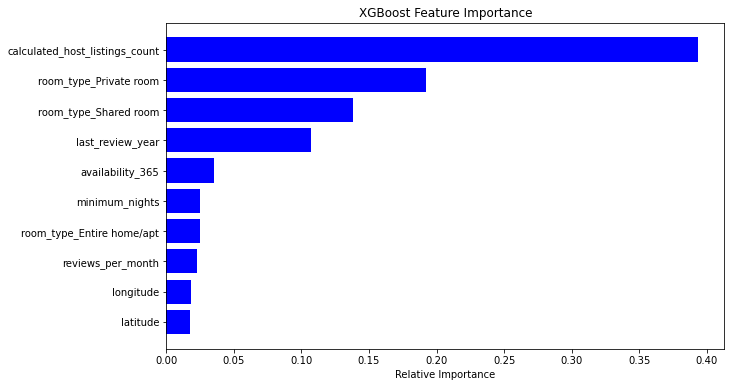


Top 10 Features for XGBoost:
calculated_host_listings_count: 0.3933
room_type_Private room: 0.1925
room_type_Shared room: 0.1384
last_review_year: 0.1074
availability_365: 0.0350
minimum_nights: 0.0248
room_type_Entire home/apt: 0.0246
reviews_per_month: 0.0227
longitude: 0.0183
latitude: 0.0172


In [10]:
# Loading the data with proper error handling (All of the below analysis is done for the previous period in the same city)
try:
    df = pd.read_csv('Austin2025Q1.csv')
except Exception as e:
    print(f"Error loading file: {e}")
    raise

# Robust data cleaning and preparation
def prepare_data(df):
    # Making a copy just in cae to avoid SettingWithCopyWarning (I recently read about this on the web, would like to get your opinion on that)
    df = df.copy()
    
    # Converting price to numeric, coercing errors
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # Removing rows with missing price as it is quite important (I could also replace the missing values with median prices, but decided that it would not be very representative)
    df = df[df['price'].notna()]
    
    # Converting numeric features, handling some errors
    numeric_cols = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                   'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'number_of_reviews_ltm']
    
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Handinge last_review date 
    df['last_review_year'] = pd.to_datetime(df['last_review'], errors='coerce').dt.year
    df['last_review_year'] = df['last_review_year'].fillna(0)
    
    # Creating has_reviews variable to show whether a specific property has a review
    df['has_reviews'] = (df['number_of_reviews'] > 0).astype(int)
    
    # Ensuring room_type is string
    df['room_type'] = df['room_type'].astype(str)
    
    # Selecting features needed and the target variable
    features = numeric_cols + ['last_review_year', 'has_reviews', 'room_type']
    target = 'price'
    
    # Dropping any remaining NA values
    df = df[features + [target]].dropna()
    
    return df

try:
    cleaned_df = prepare_data(df)
except Exception as e:
    print(f"Error preparing data: {e}")
    raise

# Splitting the data for the analysis
try:
    X = cleaned_df.drop('price', axis=1)
    y = cleaned_df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
except Exception as e:
    print(f"Error splitting data: {e}")
    raise

# Preprocessing pipeline with more robust configuration
numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                   'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'number_of_reviews_ltm', 'last_review_year']

categorical_features = ['room_type', 'has_reviews']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])  # sparse=False for compatibility

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Enhanced evaluation function with error handling
def evaluate_model(model, X_train, X_test, y_train, y_test):
    try:
        start_time = time.time()
        
        # Creating pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Fitting model with validation
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        return {
            'model': model.__class__.__name__,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'time': elapsed_time
        }
    except Exception as e:
        print(f"Error evaluating {model.__class__.__name__}: {e}")
        return {
            'model': model.__class__.__name__,
            'train_rmse': np.nan,
            'test_rmse': np.nan,
            'train_r2': np.nan,
            'test_r2': np.nan,
            'time': np.nan
        }

# Initializing models 
models = [
    LinearRegression(),
    Lasso(alpha=0.1, max_iter=5000),  # Increased max_iter for convergence
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse')
]

# Evaluating all models with error handling
results = []
for model in models:
    try:
        result = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append(result)
    except Exception as e:
        print(f"Failed to evaluate {model.__class__.__name__}: {e}")
        continue


results_df = pd.DataFrame(results)
print("\nModel Performance Results:")
print(results_df)

# Horse race table creation
print("\nHorse Race Table (sorted by test RMSE):")
print(results_df[['model', 'test_rmse', 'test_r2', 'time']].sort_values('test_rmse'))

# Plotting comparison
try:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='test_rmse', data=results_df)
    plt.title('Test RMSE Comparison')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='time', data=results_df)
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating plots: {e}")

# Featuring importance analysis with error handling
def get_feature_names(pipeline):
    try:
        preprocessor = pipeline.named_steps['preprocessor']
        numeric_feature_names = numeric_features
        categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        return np.concatenate([numeric_feature_names, categorical_feature_names])
    except Exception as e:
        print(f"Error getting feature names: {e}")
        return []

def plot_feature_importance(pipeline, feature_names, title):
    try:
        model = pipeline.named_steps['model']
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_)
            if len(importance) > len(feature_names):
                importance = importance[:len(feature_names)]
        else:
            print(f"No feature importance available for {title}")
            return None, None
        
        indices = np.argsort(importance)[-10:]  # Top 10 features
        
        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.barh(range(len(indices)), importance[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        return indices, importance
    except Exception as e:
        print(f"Error plotting feature importance for {title}: {e}")
        return None, None

# Analyzing feature importance for tree-based models
tree_models = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('XGBoost', XGBRegressor(n_estimators=100, random_state=42))
]

for name, model in tree_models:
    try:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        feature_names = get_feature_names(pipeline)
        if len(feature_names) > 0:
            indices, importance = plot_feature_importance(pipeline, feature_names, f'{name} Feature Importance')
            if indices is not None:
                print(f"\nTop 10 Features for {name}:")
                for i in reversed(indices):
                    print(f"{feature_names[i]}: {importance[i]:.4f}")
    except Exception as e:
        print(f"Error analyzing {name}: {e}")


Model Performance Results:
                       model  train_rmse   test_rmse  train_r2   test_r2  \
0           LinearRegression  537.270829  492.720092  0.080556  0.088707   
1                      Lasso  537.277118  492.777952  0.080535  0.088493   
2      RandomForestRegressor  149.693496  304.607838  0.928625  0.651711   
3  GradientBoostingRegressor  348.908281  326.099500  0.612242  0.600830   
4               XGBRegressor  114.142997  304.399930  0.958501  0.652186   

       time  
0  0.059826  
1  0.053641  
2  2.821676  
3  1.688920  
4  0.816395  

Horse Race Table (sorted by test RMSE):
                       model   test_rmse   test_r2      time
4               XGBRegressor  304.399930  0.652186  0.816395
2      RandomForestRegressor  304.607838  0.651711  2.821676
3  GradientBoostingRegressor  326.099500  0.600830  1.688920
0           LinearRegression  492.720092  0.088707  0.059826
1                      Lasso  492.777952  0.088493  0.053641


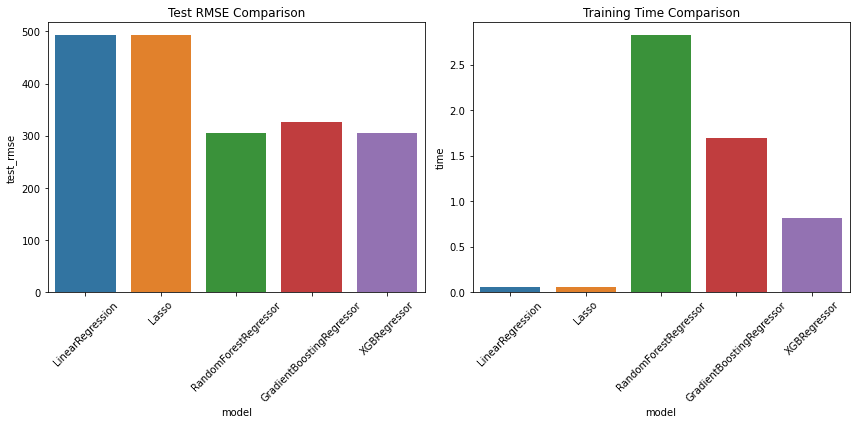

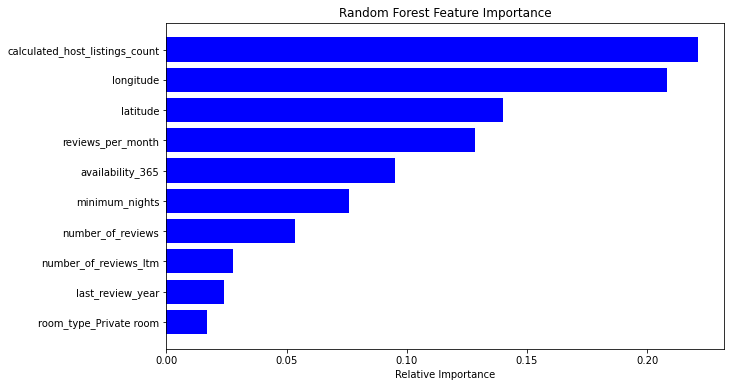


Top 10 Features for Random Forest:
calculated_host_listings_count: 0.2210
longitude: 0.2081
latitude: 0.1399
reviews_per_month: 0.1283
availability_365: 0.0949
minimum_nights: 0.0759
number_of_reviews: 0.0534
number_of_reviews_ltm: 0.0278
last_review_year: 0.0239
room_type_Private room: 0.0167


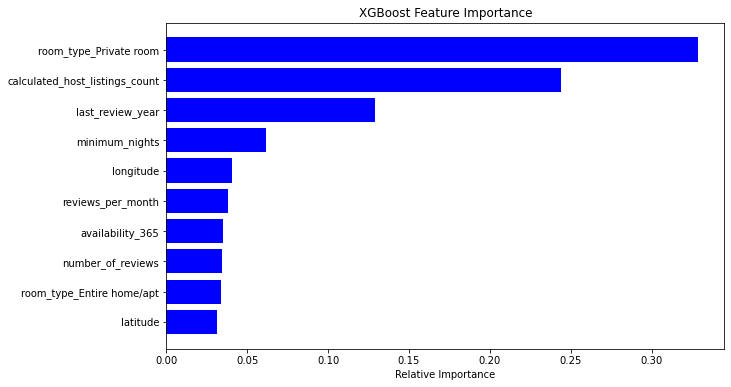


Top 10 Features for XGBoost:
room_type_Private room: 0.3285
calculated_host_listings_count: 0.2437
last_review_year: 0.1287
minimum_nights: 0.0618
longitude: 0.0403
reviews_per_month: 0.0380
availability_365: 0.0351
number_of_reviews: 0.0346
room_type_Entire home/apt: 0.0338
latitude: 0.0315


In [11]:
# Load the data with proper error handling
try:
    df = pd.read_csv('SanDiego2024Q4.csv')
except Exception as e:
    print(f"Error loading file: {e}")
    raise

# Robust data cleaning and preparation
def prepare_data(df):
    # Making a copy just in cae to avoid SettingWithCopyWarning (I recently read about this on the web, would like to get your opinion on that)
    df = df.copy()
    
    # Converting price to numeric, coercing errors
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # Removing rows with missing price as it is quite important (I could also replace the missing values with median prices, but decided that it would not be very representative)
    df = df[df['price'].notna()]
    
    # Converting numeric features, handling some errors
    numeric_cols = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                   'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'number_of_reviews_ltm']
    
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Handinge last_review date 
    df['last_review_year'] = pd.to_datetime(df['last_review'], errors='coerce').dt.year
    df['last_review_year'] = df['last_review_year'].fillna(0)
    
    # Creating has_reviews variable to show whether a specific property has a review
    df['has_reviews'] = (df['number_of_reviews'] > 0).astype(int)
    
    # Ensuring room_type is string
    df['room_type'] = df['room_type'].astype(str)
    
    # Selecting features needed and the target variable
    features = numeric_cols + ['last_review_year', 'has_reviews', 'room_type']
    target = 'price'
    
    # Dropping any remaining NA values
    df = df[features + [target]].dropna()
    
    return df

try:
    cleaned_df = prepare_data(df)
except Exception as e:
    print(f"Error preparing data: {e}")
    raise

# Splitting the data for the analysis
try:
    X = cleaned_df.drop('price', axis=1)
    y = cleaned_df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
except Exception as e:
    print(f"Error splitting data: {e}")
    raise

# Preprocessing pipeline with more robust configuration
numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                   'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'number_of_reviews_ltm', 'last_review_year']

categorical_features = ['room_type', 'has_reviews']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])  # sparse=False for compatibility

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Enhanced evaluation function with error handling
def evaluate_model(model, X_train, X_test, y_train, y_test):
    try:
        start_time = time.time()
        
        # Creating pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Fitting model with validation
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        return {
            'model': model.__class__.__name__,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'time': elapsed_time
        }
    except Exception as e:
        print(f"Error evaluating {model.__class__.__name__}: {e}")
        return {
            'model': model.__class__.__name__,
            'train_rmse': np.nan,
            'test_rmse': np.nan,
            'train_r2': np.nan,
            'test_r2': np.nan,
            'time': np.nan
        }

# Initializing models 
models = [
    LinearRegression(),
    Lasso(alpha=0.1, max_iter=5000),  # Increased max_iter for convergence
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse')
]

# Evaluating all models with error handling
results = []
for model in models:
    try:
        result = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append(result)
    except Exception as e:
        print(f"Failed to evaluate {model.__class__.__name__}: {e}")
        continue


results_df = pd.DataFrame(results)
print("\nModel Performance Results:")
print(results_df)

# Horse race table creation
print("\nHorse Race Table (sorted by test RMSE):")
print(results_df[['model', 'test_rmse', 'test_r2', 'time']].sort_values('test_rmse'))

# Plotting comparison
try:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='test_rmse', data=results_df)
    plt.title('Test RMSE Comparison')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='time', data=results_df)
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating plots: {e}")

# Featuring importance analysis with error handling
def get_feature_names(pipeline):
    try:
        preprocessor = pipeline.named_steps['preprocessor']
        numeric_feature_names = numeric_features
        categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        return np.concatenate([numeric_feature_names, categorical_feature_names])
    except Exception as e:
        print(f"Error getting feature names: {e}")
        return []

def plot_feature_importance(pipeline, feature_names, title):
    try:
        model = pipeline.named_steps['model']
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_)
            if len(importance) > len(feature_names):
                importance = importance[:len(feature_names)]
        else:
            print(f"No feature importance available for {title}")
            return None, None
        
        indices = np.argsort(importance)[-10:]  # Top 10 features
        
        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.barh(range(len(indices)), importance[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        return indices, importance
    except Exception as e:
        print(f"Error plotting feature importance for {title}: {e}")
        return None, None

# Analyzing feature importance for tree-based models
tree_models = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('XGBoost', XGBRegressor(n_estimators=100, random_state=42))
]

for name, model in tree_models:
    try:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        feature_names = get_feature_names(pipeline)
        if len(feature_names) > 0:
            indices, importance = plot_feature_importance(pipeline, feature_names, f'{name} Feature Importance')
            if indices is not None:
                print(f"\nTop 10 Features for {name}:")
                for i in reversed(indices):
                    print(f"{feature_names[i]}: {importance[i]:.4f}")
    except Exception as e:
        print(f"Error analyzing {name}: {e}")

## Comparison over time and between cities


I compared again the feature importance for RF and XGBoost models for Austin in 2024 Q4 and 2025 Q1, as well as Austin 2024 Q4 and San Diego 2024 Q4. As for the comparison in terms of RMSE and R-squared, both the other period and the other city generate pretty similar results to the initial dataset.

As we can see above, Random Forest in Austin for 2024 Q4 and 2025 Q1 has revealed that for the latter time period yearly availability has been a more important feature in determining the price of the property in that city. Similarly to the first period, the second more later period analysis also indicates that location (latitude, longitude) is an important determinant of price. Here, interestingly, RF poses quite high emphasis on minimum_nights compared to 2024 Q4. Moreover, XGBoost entails that property type (room_type), specifically private room and shared room, still remains a critical factor. Therefore, as no major economic things happened during this time periods, they feature quite similar results.

As for the comparison across 2 cities in US in the same time period, we may see that in San Diego, location in terms of latitude and longitude plays a significant role in the pricing model RF and a little bit less in XGBoost. What is interesting in this case, the type of the property in terms of a private room has quite high emphasis in XGBoost than in RF, the difference is really high (I did an analysis of why that difference is high in the two models, but would like to discuss with you further). Availability 365 feature (specifically from the XGBoost model), as well as minimum nights are more crucial for San Diego than for Austin. Additionally, reviews per month played a more crucial role in San Diego based on RF model.